# Project 5 - Intro to Deep Learning Image Classification

### What to Submit
Submit this iPython Notebook--containing all your code for the programming exercises below--on [LearningSuite](https://learningsuite.byu.edu/).

Your notebook file should produce the relevant plots and also provide a short write-up with answers to the questions below (at the end of this notebook).

<span style="color:red">PLEASE submit only the notebook -- no additional files.</span>

Please also fill in here the time that each part took you:
1. Part A - Dataset: <span style="color:red;">About 1 hour</span>
2. Part B - Neural Network Architecture: <span style="color:red;">About 15 minutes</span>
3. Part C - Network Training: <span style="color:red;">About 30 minutes (for setting up the code, not the actual training time)</span>
4. Part D - Testing: <span style="color:red;">About 10 minutes</span>
5. Write-up: <span style="color:red;">About 15 minutes</span>

## Background - Image Classification

For this project you will be introduced to the basics of deep learning and the PyTorch framework.  Deep learning can be very computationally expensive and runs fastest with GPU support.  If you do not have access to NVIDIA GPUs on your local machine, you can use some from Google using their [colab tool](https://colab.research.google.com).  Colab runs exactly like jupyter notebooks and you can directly upload your .ipynb file.

Image classification is the task of taking an image and labeling it as a category.  Deep learning has been the leading method for image classification since it dominated the [ImageNet competition in 2012](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf).

# Part A: Dataset

You will be performing classification on the [Stanford Cars Dataset](https://ai.stanford.edu/~jkrause/cars/car_dataset.html), which consists of 16,185 images of 196 classes of cars.  The dataset is split 50-50 into a training set and testing set.  You will want to download each one idividually from Stanford's site or use these links: [Train Set](http://imagenet.stanford.edu/internal/car196/cars_train.tgz) and [Test Set](http://imagenet.stanford.edu/internal/car196/cars_test.tgz).  Each set is around 1 GB of data so please **<span style="color:red">DO NOT</span>** include the files when you upload your notebook--**just turn in the .ipynb file**.  Assume the notebooks will be run with the images in folders labeled `cars_train` and `cars_test` like so:

```
.
+--proj5-image-classification.ipynb
+--cars_train
|  +--00001.jpg
|  +--00002.jpg
|  +--...
+--cars_test
|  +--00001.jpg
|  +--00002.jpg
|  +--...
+--test_annos.json
+--train_annos.json
```

The first step in any deep learning method is to make sure you can read in the data.  Since there will be a lot of images for this project, it is possible not all of them will fit into memory.  This is a common problem in deep learning and PyTorch has provided a pattern so as to only have the images you need in memory at a time.  They provide a class called `DataLoader` that acts as an iterable object.  To use `DataLoader`, you will need to implement a subclass of PyTorch's `Dataset` class.  To do you so will need to create a class that inherits from `Dataset` and implements the methods `__getitem__` and `__len__`.  An example is given below and PyTorch provides a [tutorial here](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html):

```Python
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self):
        super(MyDataset, self).__init__()
#         TODO: implement what happens when someone calls: 
#         dataset = MyDataset()
    
    def __getitem__(self, idx):
#         TODO: implement what happens when someone calls dataset[idx]
#         This typically will return an image and its label 
    
    def __len__(self):
#         TODO: implement what happens when someone calls len(dataset)

dataset = MyDataset()
loader = DataLoader(dataset)
for im, label in loader:
#     TODO: Perform operations
```

We provide you with two files: `test_annos.json` and `train_annos.json`.  These files contain a dictionary mapping image name to the class label the image belongs to.  You can use these files in you Dataset class in order to provide the ground truth labels.  For part A, you will need to implement a dataset class.

**Note:** Both the images and the labels are 1-indexed. You can load the images however you choosed, but the labels must be 0-indexed to work with Pytorch's loss functions. Make sure to account for this in your Dataset class.

In [1]:
# Mount google drive for accessing files
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/Colab Notebooks/'

Mounted at /content/drive


In [2]:
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets.utils import download_url
import torch
import torchvision
import torchvision.transforms as transforms
import tarfile
import cv2
import numpy as np
import json
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [3]:
plt.rcParams['figure.figsize'] = [15,8]
plt.rcParams['axes.titlesize'] = '16'
plt.rcParams['axes.titleweight'] = 'bold'

def just_title(title):
    a = plt.gca()
    a.set_title(title, fontdict={'fontsize': plt.rcParams['axes.titlesize'],
                                 'fontweight' : plt.rcParams['axes.titleweight'],
                                 'verticalalignment': 'baseline',
                                 'horizontalalignment': 'center'})
    a.set_xticks([])
    a.set_yticks([])

In [4]:
class TrainDataset(Dataset):
  def __init__(self, transform=None, root_dir='./data', img_name_len=5):
      super(TrainDataset).__init__()
      self.transform = transform
      self.root_dir = root_dir
      self.img_name_len = img_name_len
      dataset_url = "http://ai.stanford.edu/~jkrause/car196/cars_train.tgz"
      download_url(dataset_url, self.root_dir)

      with tarfile.open(f'{self.root_dir}/cars_train.tgz', 'r:gz') as tar:
          tar.extractall(path=self.root_dir)

      with open(f'{file_path}train_annos.json', 'r') as fp:
          self.labels = json.load(fp)
          

  def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = str(str(idx + 1)).zfill(self.img_name_len) + '.jpg'
        image = cv2.imread(f'{self.root_dir}/cars_train/{img_name}')
        label = self.labels[img_name] - 1

        if self.transform is not None:
            transformed_img = self.transform(image)

            return transformed_img, label

        return image, label

  def __len__(self):
      return len(self.labels)

In [5]:
class TestDataset(Dataset):
  def __init__(self, transform=None, root_dir='./data', img_name_len=5):
      super(TestDataset).__init__()
      self.transform = transform
      self.root_dir = root_dir
      self.img_name_len = img_name_len
      dataset_url = "http://ai.stanford.edu/~jkrause/car196/cars_test.tgz"
      download_url(dataset_url, self.root_dir)

      with tarfile.open(f'{self.root_dir}/cars_test.tgz', 'r:gz') as tar:
          tar.extractall(path=self.root_dir)

      with open(f'{file_path}test_annos.json', 'r') as fp:
          self.labels = json.load(fp)
          

  def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = str(str(idx + 1)).zfill(self.img_name_len) + '.jpg'
        image = cv2.imread(f'{self.root_dir}/cars_test/{img_name}')
        label = self.labels[img_name] - 1

        if self.transform is not None:
            transformed_img = self.transform(image)

            return transformed_img, label

        return image, label

  def __len__(self):
      return len(self.labels)

In [6]:
transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize((400, 400)),
                                transforms.ToTensor(), 
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
validation_transform = transforms.Compose([transforms.ToPILImage(),
                                           transforms.Resize((400, 400)),
                                           transforms.ToTensor(), 
                                           transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

train_set = TrainDataset(transform=transform)
train_set_size = int(len(train_set) * 0.9)
validation_set_size = len(train_set) - train_set_size
train_set, validation_set = torch.utils.data.random_split(train_set, lengths=[train_set_size, validation_set_size])
validation_set.transform = validation_transform
test_set = TestDataset(transform=transform)

  0%|          | 0/979269282 [00:00<?, ?it/s]

  0%|          | 0/977350468 [00:00<?, ?it/s]

In [7]:
batch_size = 16

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False, num_workers=2)

# Part B: Neural Network Architecture

The main backbone for deep learning is the actual neural network architecture.  For image classification, this will consist of some combination of `Conv2d` layers with activations--usually `ReLU`--with intermittent downsampling--usually done using `MaxPool2d`--followed by a few Linear layers.  The input to the network should be an image with shape `(batch_size, channels, image_height, image_width)`(e.g. a single RGB image with dimensions 224x224 would be `(1, 3, 224, 224)`) and the output a vector of shape `(num_classes,)`, where the largest value's index in the output vector indicates the class label.  

While we built our own network in the Learning Lab, for this lab we will used one of Pytorch's pretrained networks. This has the benefit of already having learned features from training on an ImageNet classification problem. To pull in this pretrained network, we use the following line of code:

In [7]:
model = torchvision.models.resnet18(pretrained=True)

print(list(model.__dict__["_modules"].keys()))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc']


The ResNet18 is a state of the art network that uses convolution layers, batch normalization, layers of residual blocks, and a fully connected layer at the end. The different layers are listed above. However, because the pretrained network was trained on ImageNet, the last layer is designed to predict 1000 classes, not 196 like in our dataset.

In [8]:
print(model.fc)

Linear(in_features=512, out_features=1000, bias=True)


Our goal is to use the same architecture as the ResNet, but replace the last fully connected layer with a new fully connected layer that goes from 512 input features to 196 output features.

PyTorch provides a nice framework for making a neural network architecture.  A network is typically made as a class that inherits from PyTorch's `Module` class and implements the `forward` method.  A network might take the form of the example below. PyTorch also provides a simple Neural Network [tutorial here](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) -- the Training a Classifier tutorial is especially helpful.
```Python
import torch.nn as nn 

class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
#         TODO: setup network here

    def forward(self, x):
#         TODO: perform the forward pass, which happens when someone calls network(x)
```

Take all the pretrained layers from ResNet18, but then define your own last fully connected layer. Then write the appropriate forward pass function.

**Note:** ResNet was trained with images that are normalized according to the ImageNet color averages. This means you may want to include an appropriate normalization in your Dataset class if you did not already. This can easily be done with Pytorch's transform objects.

```Python
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
```

In [9]:
class ImageClassifier(nn.Module):
    def __init__(self):
        super(ImageClassifier, self).__init__()

        pretrained_model = torchvision.models.resnet18(pretrained=True)
        layers = list(pretrained_model.children())[:-1] + [nn.Linear(512, 196)]

        self.conv1, self.bn1, self.relu, self.maxpool, self.layer1, self.layer2, self.layer3, self.layer4, self.avgpool, self.fc = layers
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = self.fc(x.reshape(-1, 512))

        return x

# Part C: Training

Now that you can access your data and you have a network architecture set up, its time to put things together and start training.  Training requires two additional major components: 1) the loss function and 2) the optimizer.  The loss function is a comparison between your results and the ground truth data.  The optimizer is what takes the results of the loss function and backpropagates the error to the network weights in an attempt to decrease the loss.  The most common loss function used for classification is [Cross Entropy](https://pytorch.org/docs/stable/nn.html#crossentropyloss) while the most commonly used optimizer is [Adam](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam).  

A basic training step might take the following form:
```Python
optimizer.zero_grad()
outs = model(inputs)
loss = loss_func(outs, labels)  # loss_func would be an instance of a torch.nn.CrossEntropyLoss class
loss.backward()
optimizer.step()  # optimizer would be an instance of the torch.optim.Adam class
```

For deliverables on this section, please display a plot of the value of the loss over time.  If things are working, the loss should be decreasing.

**Note: This step could take several hours so you will want to look into being able to save your model to a file and load it up again.** See [here](https://pytorch.org/docs/stable/notes/serialization.html).

Also, if you are running on Google Colab, your notebook may eventually get disconnected -- Colab limits the amount of time you can spend using their service at one time. You may want to save intermediate results to your Google Drive: see [here](https://medium.com/@ml_kid/how-to-save-our-model-to-google-drive-and-reuse-it-2c1028058cb2).

In [10]:
def validate():
    validate_loss = []
    
    for x, y_truth in validation_loader:
        if torch.cuda.is_available():
            x, y_truth = x.cuda(), y_truth.cuda()
        
        y_hat = image_classifier(x)
        
        loss = loss_fn(y_hat, y_truth)
        
        validate_loss.append(loss.item())
      
    return np.mean(validate_loss)

def train(model_file_name, model, loss_fn, optimizer, n_epochs, n_epochs_without_change_limit):
    prev_validation_loss, n_epochs_without_change = np.inf, 0
    losses, validation_losses = [], []

    for epoch in range(n_epochs):
        print(f'Epoch: {epoch + 1}')
        epoch_losses, running_loss = [], 0.0

        validation_loss = validate()
        validation_losses.append(validation_loss)

        if validation_loss < prev_validation_loss:
            prev_validation_loss = validation_loss
            n_epochs_without_change = 0
            torch.save(model, f'{file_path}{model_file_name}')

        else:
            n_epochs_without_change += 1

        if n_epochs_without_change >= n_epochs_without_change_limit:
            print('EARLY STOPPING CRITERIA REACHED - CANCELLING REMAINING EPOCHS')
            break

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data

            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            epoch_losses.append(loss.item())

            loss.backward()
            optimizer.step()

        losses.append(np.mean(epoch_losses))

    return losses, validation_losses

In [11]:
torch.cuda.is_available()

True

In [13]:
image_classifier = ImageClassifier()
if torch.cuda.is_available():
    image_classifier.cuda()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(image_classifier.parameters(), lr=0.0001)
n_epochs, pct_of_epochs_for_stop = 100, 0.10
n_epochs_without_change_limit = int(n_epochs * pct_of_epochs_for_stop)

losses, validation_losses = train('cs450_model.pth', image_classifier, loss_fn, optimizer, n_epochs, n_epochs_without_change_limit)

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
EARLY STOPPING CRITERIA REACHED - CANCELLING REMAINING EPOCHS


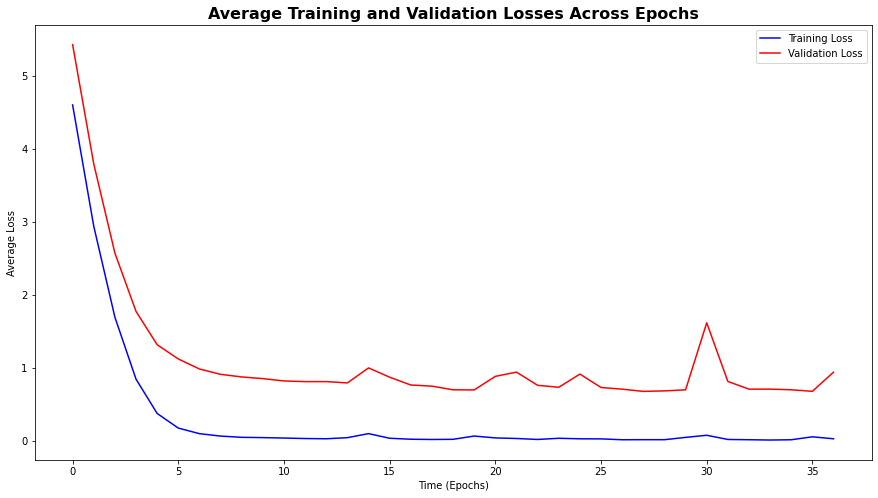

In [14]:
min_len = min(len(losses), len(validation_losses))
plt.plot(losses[:min_len], '-b', label='Training Loss')
plt.plot(validation_losses[:min_len], '-r', label='Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Average Training and Validation Losses Across Epochs')
plt.xlabel('Time (Epochs)')
plt.ylabel('Average Loss')
plt.show()

In [43]:
# image_classifier = torch.load(f'{file_path}cs450_model.pth')

# if torch.cuda.is_available():
#     image_classifier.cuda()

# Part D: Testing

One of the goals of deep learning is to make a model that generalizes to data it has never seen (e.g. new images of cars).  For this part, you will test your generalizability by running the model on a dataset it has not yet seen during training.  To do so, you will need to make sure you are not calculating any gradients by using `torch.no_grad` in a with statement. You will also need to put the network into evaluation mode:
```Python
model.eval()
with torch.no_grad():
    # enter testing code here
```

To put the network back into training mode, call `model.train()`.

You will also need to compare your actual predictions with the ground truth, value for value.  The output of your network, however, will be a vector of length 196 (the number of possible classes for the cars dataset) with the largest value representing the guessed class.  You will need to extract the predicted class number and compare it with the ground truth class number for all images in the test dataset and calculate the overall accuracy.  **Print out the overall accuacy of your model**.

Additionally, **you will need to generate a confusion matrix of the 196 categories**. A confusion matrix shows how often a specific category is guessed as each other category. For example, the 11th row and 34th column in the matrix should tell you how many times category 11 images were guessed to be category 34 images. Thus, a perfect predictor on the test set would have nonzero values only along the diagnol. Once you generated the confusion matrix, you may simply plot it as a grayscale image (with interpolation turned off).

While high test accuracy is not the only goal in this lab, most students are able to get above 50% in their testing accuracy. If you are unable to reach this level of accuracy, it may indicate an error in your code.

In [12]:
def get_test_results():
    correct = 0
    total = 0
    confusion_matrix = np.zeros((196, 196))

    with torch.no_grad():
        for data in test_loader:
            images, labels = data

            if torch.cuda.is_available():
                images = images.cuda()

            outputs = image_classifier(images)
            _, predicted = torch.max(outputs.data, 1)

            if torch.cuda.is_available():
                labels = labels.cuda()

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            for label, prediction in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[label.long()][prediction.long()] += 1

    accuracy = round(100 * (correct / total), 5)

    return accuracy, total, confusion_matrix

Accuracy on 8041 test images: 78.70912% (rounded to five decimal places)


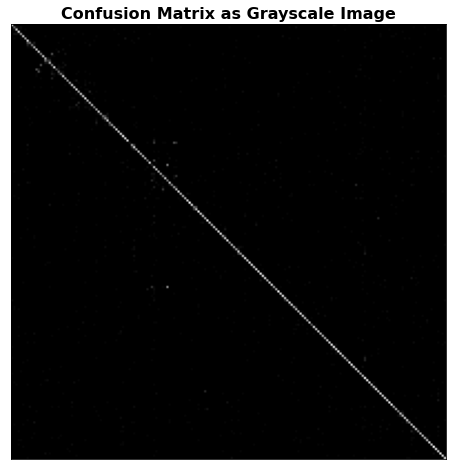

In [16]:
accuracy, total, confusion_matrix = get_test_results()

print(f'Accuracy on {total} test images: {accuracy}% (rounded to five decimal places)')

plt.imshow(confusion_matrix, cmap=plt.get_cmap('gray'))
just_title('Confusion Matrix as Grayscale Image')

### Relection Data Augmentation

In [17]:
transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize((400, 400)),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(), 
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
validation_transform = transforms.Compose([transforms.ToPILImage(),
                                           transforms.Resize((400, 400)),
                                           transforms.ToTensor(), 
                                           transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

train_set = TrainDataset(transform=transform)
train_set_size = int(len(train_set) * 0.9)
validation_set_size = len(train_set) - train_set_size
train_set, validation_set = torch.utils.data.random_split(train_set, lengths=[train_set_size, validation_set_size])
validation_set.transform = validation_transform
test_set = TestDataset(transform=transform)

Using downloaded and verified file: ./data/cars_train.tgz
Using downloaded and verified file: ./data/cars_test.tgz


In [18]:
batch_size = 16

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False, num_workers=2)

In [19]:
image_classifier = ImageClassifier()
if torch.cuda.is_available():
    image_classifier.cuda()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(image_classifier.parameters(), lr=0.0001)
n_epochs, pct_of_epochs_for_stop = 100, 0.10
n_epochs_without_change_limit = int(n_epochs * pct_of_epochs_for_stop)

losses, validation_losses = train('cs450_model_with_augmentation.pth', image_classifier, loss_fn, optimizer, n_epochs, n_epochs_without_change_limit)

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
EARLY STOPPING CRITERIA REACHED - CANCELLING REMAINING EPOCHS


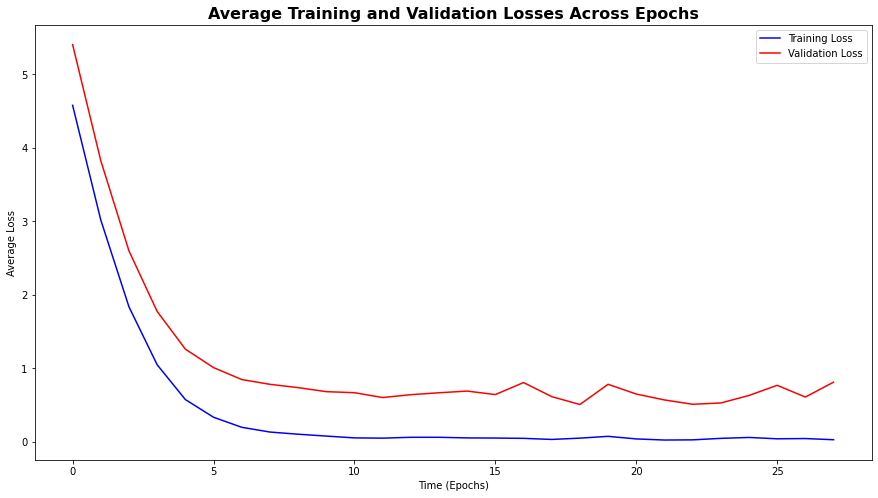

In [20]:
min_len = min(len(losses), len(validation_losses))
plt.plot(losses[:min_len], '-b', label='Training Loss')
plt.plot(validation_losses[:min_len], '-r', label='Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Average Training and Validation Losses Across Epochs')
plt.xlabel('Time (Epochs)')
plt.ylabel('Average Loss')
plt.show()

Accuracy on 8041 test images: 86.35742% (rounded to five decimal places)


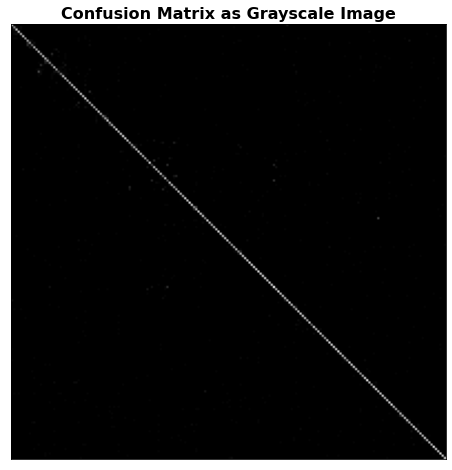

In [21]:
accuracy, total, confusion_matrix = get_test_results()

print(f'Accuracy on {total} test images: {accuracy}% (rounded to five decimal places)')

plt.imshow(confusion_matrix, cmap=plt.get_cmap('gray'))
just_title('Confusion Matrix as Grayscale Image')

### Varying Batch Sizes

In [13]:
transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize((400, 400)),
                                transforms.ToTensor(), 
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
validation_transform = transforms.Compose([transforms.ToPILImage(),
                                           transforms.Resize((400, 400)),
                                           transforms.ToTensor(), 
                                           transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

train_set = TrainDataset(transform=transform)
train_set_size = int(len(train_set) * 0.9)
validation_set_size = len(train_set) - train_set_size
train_set, validation_set = torch.utils.data.random_split(train_set, lengths=[train_set_size, validation_set_size])
validation_set.transform = validation_transform
test_set = TestDataset(transform=transform)

Using downloaded and verified file: ./data/cars_train.tgz
Using downloaded and verified file: ./data/cars_test.tgz


In [14]:
batch_sizes = [4, 8]
batch_losses, batch_val_losses, batch_accuracies, batch_conf_matrices = [], [], [], []

for batch_size in batch_sizes:
    print(f'BATCH SIZE: {batch_size}')
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)
    validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False, num_workers=2)
    
    image_classifier = ImageClassifier()
    if torch.cuda.is_available():
        image_classifier.cuda()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(image_classifier.parameters(), lr=0.0001)
    n_epochs, pct_of_epochs_for_stop = 100, 0.10
    n_epochs_without_change_limit = int(n_epochs * pct_of_epochs_for_stop)

    losses, validation_losses = train(f'cs450_model_batch_{batch_size}.pth', image_classifier, loss_fn, optimizer, n_epochs, n_epochs_without_change_limit)

    batch_losses.append(losses)
    batch_val_losses.append(validation_losses)

    accuracy, total, confusion_matrix = get_test_results()

    batch_accuracies.append((accuracy, total))
    batch_conf_matrices.append(confusion_matrix)

BATCH SIZE: 4
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
EARLY STOPPING CRITERIA REACHED - CANCELLING REMAINING EPOCHS
BATCH SIZE: 8
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
EARLY STOPPING CRITERIA REACHED - CANCELLING REMAINING EPOCHS


In [18]:
def display_batch_results(i):
    batch_size, batch_loss, batch_val_loss, batch_accuracy, batch_conf_matrix = batch_sizes[i], batch_losses[i], batch_val_losses[i], batch_accuracies[i], batch_conf_matrices[i]

    print(f'BATCH SIZE: {batch_size} -- TEST ACCURACY: {batch_accuracy[0]}')

    plt.subplot(121)
    min_len = min(len(batch_loss), len(batch_val_loss))
    plt.plot(batch_loss[:min_len], '-b', label='Training Loss')
    plt.plot(batch_val_loss[:min_len], '-r', label='Validation Loss')
    plt.legend(loc = 'upper right')
    plt.title(f'Average Training and Validation Losses Across Epochs - Batch Size = {batch_size}')
    plt.xlabel('Time (Epochs)')
    plt.ylabel('Average Loss')
    plt.show()

    plt.subplot(122)
    plt.imshow(confusion_matrix, cmap=plt.get_cmap('gray'))
    just_title(f'Confusion Matrix as Grayscale Image - Batch Size = {batch_size}')

BATCH SIZE: 4 -- TEST ACCURACY: 77.6396


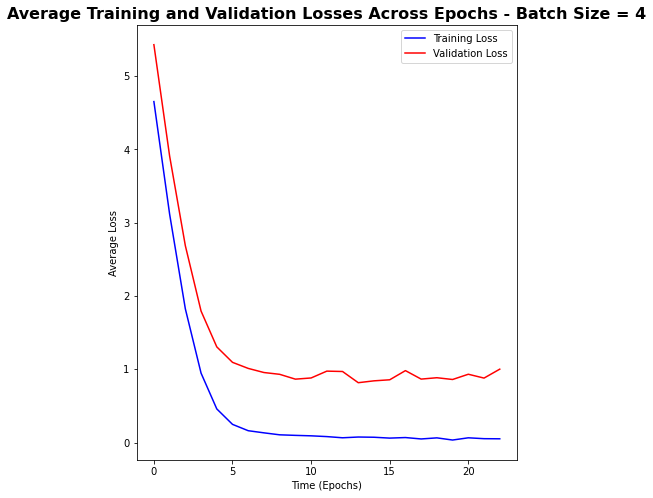

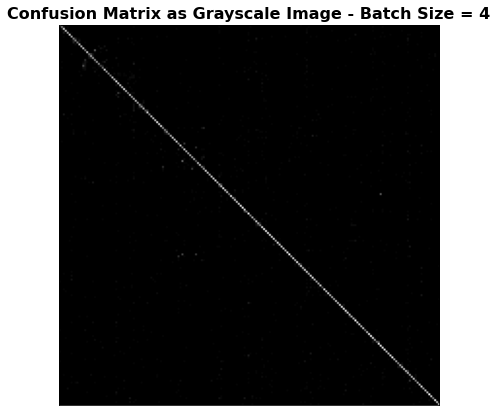

In [19]:
display_batch_results(0)

BATCH SIZE: 8 -- TEST ACCURACY: 77.27895


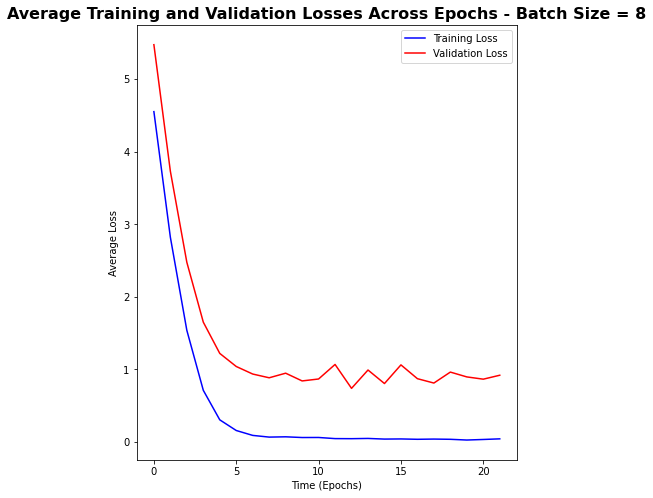

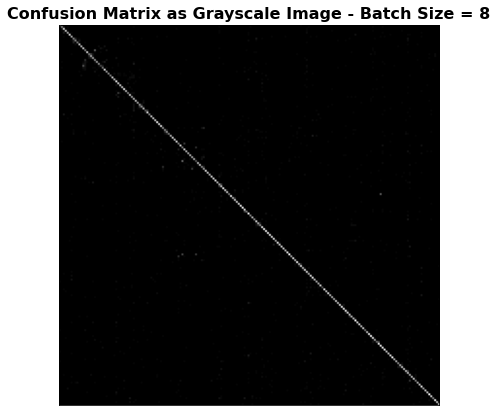

In [20]:
display_batch_results(1)

## Grading
Points for this assigment will be assigned as follows (100 points total):
* [20 pts] Making a Dataset class
* [10 pts] Setting up you architecture
* [20 pts] Training your model and plotting training loss
* [30 pts] Displaying the overall accuracy of your model and a confusion matrix

The last 20 points are earned through completing a subset of the following explorations:
* [10 pts] Enhance your dataloader to include reflection data augmentation (i.e. double the size of your training data by taking the mirror image across the y-axis). **DO NOT** do reflection augmentation across the x-axis (we don't care to detect cars when they are upside down!). Describe what effects the augmentation had on testing accuracy.
* [10 pts] Enhance your dataloader to include random resized crop data augmentation (i.e. increase the size of your training data by taking a subsection of your image each time). Make sure the crop is not too small, otherwise you might miss parts of the car. Describe what effects the augmentation had on testing accuracy.
* [10 pts] Analyze the effect of learning rates on the accuracy of the network. Describe what you found and give supporting plots.
* [10 pts] Analyze the effect of changing the number of training epochs on the accuracy of the network. Describe what you found and give supporting plots.
* [10 pts] Analyze the effect of varying the batch_size on the accuracy of the network. Describe what you found and give supporting plots. 
* [10 pts] Analyze the effect of different optimizers on the accuracy of the network. Describe what you found and give supporting plots. A list of optimizers in Pytorch can be found [here](https://pytorch.org/docs/stable/optim.html).
* [10 pts] Analyze the effect of different pretrained networks on the accuracy of the network. Describe what you found and give supporting plots. A list of pretrained networks in Pytorch can be found [here](https://pytorch.org/docs/stable/torchvision/models.html).

You may earn up to 10 points extra credit for additional explorations you complete.

An additional 15 points of extra credit will be given to the individual with the highest test accuracy.


## Write-up:
Provide an explanation for the following items:
* <span style="color:red;">Which part of this lab did you find most difficult?</span>  Setting up the dataset was probably the most difficult for me.  First of all, I'm not used to using the dataset class (I usually just import data via pandas).  Second, my go-to framework for deep learning is TensorFlow, so I had to work through some syntax issues.
* <span style="color:red;">What insight did you gain from analyzing the confusion matrix?</span>  The confusion matrix was useful to see which types of cars tended to be classified correctly/incorrectly.  If incorrectly, it also helps to show which type of car it was actually labeled as.
* <span style="color:red;">What insight did you gain from your explorations?</span>  I made three improvements for this lab.  (1) I used a portion of the training set as a validation set in order to enable early stopping.  This approach typically improves restuls on the test set and almost always reduces training time.  (2) I used reflection data in the training set (added it as part of the data transformation) in order to improve car recognition (as the data augmentation serves as a form of regularization).  The accuracy on the test set indeed improved from roughly 79% to 86%.  Finally, (3) I used 2 different batch sizes (in addition to the original batch size of 16 for a total of 3 different batch sizes) to see which batch size seemed to be best.  A batch size of 16 seemed to be the best, while the accuracies of 4 and 8 batch sizes were almost the same (about a 0.4% difference between the two).  It's possible that these results might have been different without early stopping via validation accuracy.  For all three of these improvements, please see the graphs and output statements from the previous sections/code cells for more details.
* <span style="color:red;">What improvements would you recommend for this lab?</span>  I'm much more familiar with deep learning than the other concepts in this class and therefore found this lab to be much simpler/easier.  As such, I don't have much feedback for you guys other than I wish I could have used TensorFlow instead of PyTorch.  This is both because I'm much more familiar with TensorFlow as well as the fact that native GPU support works with TensorFlow on the newer mac M1 chips (whereas PyTorch does not), so I could have run this notebook on my computer instead of using Colab and having to wait for GPU access.